In [1]:
import torch

seed = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu = 'cpu'

torch.manual_seed(seed)

print(f'Using \'{device}\' device')

Using 'cpu' device


In [2]:
# import torch.utils.data as td
# from torchvision import datasets
# import torchvision.transforms as tns 

# n_classes = 10

# dataset = td.ConcatDataset([
#     datasets.FashionMNIST('data', train=True, download=True, transform=tns.ToTensor()),
#     datasets.FashionMNIST('data', train=False, download=True, transform=tns.ToTensor())
# ])
# image_shape = dataset[0][0].shape
# image_channels, image_height, image_width = image_shape

# print(f'Concatenated dataset has {len(dataset)} samples')

Concatenated dataset has 70000 samples


In [15]:
import torch.utils.data as td
from torchvision import datasets
import torchvision.transforms as tns 

scale_unit = 2 / image_width

transform = tns.Compose([
    tns.ToTensor(),
    tns.RandomAffine(0, scale=(1 - scale_unit, 1 + scale_unit)),
    tns.ColorJitter(brightness=(0.5, 1.5))
])

dataset = td.ConcatDataset([
    datasets.FashionMNIST('data', train=True, download=True, transform=transform),
    datasets.FashionMNIST('data', train=False, download=True, transform=transform)
])

image_shape = dataset[0][0].shape
image_channels, image_height, image_width = image_shape
n_classes = 10
augmented_dataset = dataset

print(f'Concatenated dataset has {len(dataset)} samples')

Concatenated dataset has 70000 samples


In [4]:
import matplotlib.pyplot as plt
from math import ceil

cmap = 'gray'

label_map_dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


def label_map(label):
    return label_map_dict[label] if isinstance(label, int) else list(label_map_dict.values()).index(label)


def plot_image(image):
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

def plot_images(images, image_size=2.5, per_row=5):
    rows = ceil(len(images) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        image = images[i]
        figure.add_subplot(rows, per_row, i + 1)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

    plt.show()

def plot_dataset(dataset, ids=None, last_index=None, image_size=2.5, per_row=5, plot_labels=True):
    if ids is None:
        ids = list(range(last_index if last_index is not None else len(dataset)))

    rows = ceil(len(ids) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        if i >= len(ids):
            break

        image, label = dataset[ids[i]]
        figure.add_subplot(rows, per_row, i + 1)
        if plot_labels:
            plt.title(label_map(label))
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

    plt.show()

In [4]:
from typing import Callable

class GaussianNoise(Callable):
    def __init__(self, std=0.1):
        self.std = str

    def __call__(self, tensor):
        return torch.clip(tensor + self.std * torch.randn_like(tensor, device=device), 0, 1)

In [5]:
import time

augmented_dataset = []
scale_unit = 2 / image_width

def time_to_str(t):
    m = int(t) // 60
    s = int(t) % 60
    
    string = ''
    if m > 0:
        string += f'{m}m '
    string += f'{s}s'
    
    return string

start_time = time.time()

for s in [-1, 0, 1]:
    for b in [0.5, 0.75, 1, 1.25, 1.5]:
        scale = 1 + s * scale_unit
        
        transform = tns.Compose([
            tns.RandomAffine(0, scale=(scale, scale)),
            tns.ColorJitter(brightness=(b, b))
        ])
        
        for X, y in td.DataLoader(dataset, len(dataset)):
            augmented_dataset.extend(list(zip(transform(X.to(device)).to(cpu), y.tolist())))

total_time = time.time() - start_time

print(f'Dataset has been augmented in {len(augmented_dataset)} samples (' + time_to_str(total_time) + ')')

Dataset has been augmented in 1050000 samples (1m 6s)


In [17]:
val_size = 10000

train_size = len(augmented_dataset) - val_size
train_dataset, val_dataset = td.random_split(augmented_dataset, [train_size, val_size])

print(f'Dataset has been split in the ratio of {train_size} : {val_size}')

Dataset has been split in the ratio of 60000 : 10000


In [21]:
reduced_train_size = 200000

if reduced_train_size is not None:
    reduced_train_dataset = td.Subset(train_dataset, list(range(reduced_train_size)))

In [18]:
def classify(output):
    return torch.argmax(output, dim=1)

def compute_accuracy(pred, y):
    return pred.eq(y).sum().item() / len(y)

def compute_error(pred, y):
    return pred.ne(y).sum().item() / len(y)

def load_model(model, path):
    return model.load_state_dict(torch.load(path))

def number_of_parameters(model):
    n = 0
    for p in model.parameters():
        n += torch.prod(torch.as_tensor(p.size()))
    return n

In [23]:
import torch.nn as nn
import time

train_eval_max_size = 100000
    
def train(model, 
          train_dataset, 
          val_dataset=None, 
          epochs=None, 
          lr=1e-3, 
          max_lr=1e-2, 
          weight_decay=0.01, 
          batch_size=512, 
          save=False, 
          saving_prefix='', 
          verbose=False
         ):
    model = model.to(device)
    
    train_loader = td.DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = td.DataLoader(val_dataset, batch_size)
    
    if epochs is None:
        epochs = 1000000
    
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    train_eval_max_batches = min(train_eval_max_size // batch_size, len(train_loader))
    start_time = time.time()
    
    if verbose:
        print(f'Training model with {number_of_parameters(model)} parameters...')
    
    for epoch in range(1, 1 + epochs):
        model.train()
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fun(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scheduler.step()
        
        if verbose:
            with torch.no_grad():
                model.eval()
                train_error, train_loss = 0, 0
                val_error, val_loss = 0, 0
                
                for b, (X, y) in enumerate(train_loader):
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    train_loss += loss_fun(pred, y)
                    train_error += compute_error(classify(pred), y)
                    
                    if b + 1 >= train_eval_max_batches:
                        break
                
                train_loss /= train_eval_max_batches
                train_error /= train_eval_max_batches
                
                if val_dataset is not None:
                    for X, y in val_loader:
                        X, y = X.to(device), y.to(device)
                        pred = model(X)
                        val_loss += loss_fun(pred, y)
                        val_error += compute_error(classify(pred), y)
                        
                    val_loss /= len(val_loader)
                    val_error /= len(val_loader)
                    
                    print(f'{epoch:2d} - error: {train_error:.3f}/{val_error:.3f} - loss: {train_loss:.3f}/{val_loss:.3f}', end='')
                else:
                    print(f'{epoch:2d} - error: {train_error:.3f} - loss: {train_loss:.3f}', end='')
                
            elapsed_time = time.time() - start_time
            print(f' - elapsed time: {elapsed_time:3.0f}s')
    
        if save:
            torch.save(model.state_dict(), 'models/' + saving_prefix + '_e' + str(epoch) + '.pt')

In [20]:
!rm models/*

rm: cannot remove 'models/*': No such file or directory


In [21]:
!ls models

ls: cannot access 'models': No such file or directory


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        identity = x if self.stride == 1 else self.downsample(x)
        return self.relu(self.block(x) + identity)
    
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, blocks=2, stride=1):
        super().__init__()
        
        out_channels = 2 * in_channels
        layers = [ResNetBlock(in_channels, out_channels, stride)]
        
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class MyNet(nn.Module):
    def __init__(self, channels=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            
            ResNetLayer(channels, stride=2),
            ResNetLayer(2 * channels, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            
            nn.Linear(2 * 2 * channels, 32),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        return self.model(x)

resnet1 = MyNet()
    
train(resnet1,
      train_dataset,
      val_dataset,
      10,
      lr=1e-6,
      max_lr=1e-2,
      weight_decay=0.01,
      save=True,
      saving_prefix='resnet1',
      verbose=True
     )

Training model with 43960 parameters...
 1 - error: 0.232/0.237 - loss: 0.634/0.639 - elapsed time: 100s


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = resnet1
dataset_to_analyze = dataset

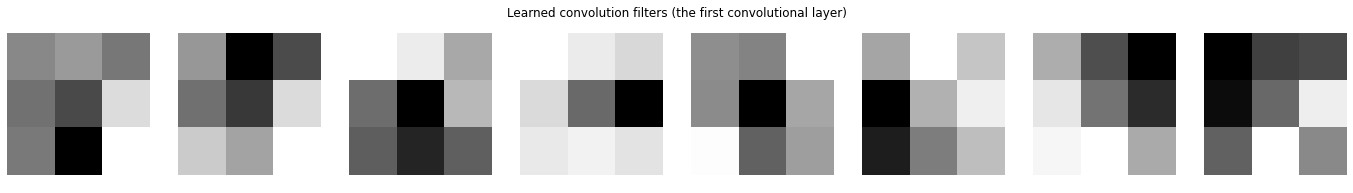

In [24]:
plot_size = 3

conv_filters = list(model.parameters())[0].squeeze().to(cpu).detach()
n = len(conv_filters)

figure = plt.figure(figsize=(n * plot_size, plot_size))
plt.title('Learned convolution filters (the first convolutional layer)')
plt.axis("off")

for i, cf in enumerate(conv_filters):
    figure.add_subplot(1, n, i + 1)
    plt.axis("off")
    plt.imshow(cf, cmap='gray')

plt.show()

Text(0.5, 1.0, 'Misclassified samples')

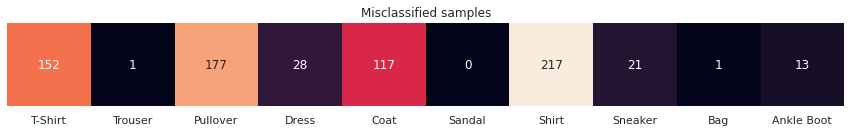

In [25]:
plot_scale = 1.5
sns.set(font_scale=1)

def get_ground_truth_and_predictions(dataset, batch_size = 1024):
    n = len(dataset)
    y = torch.Tensor(n)
    pred = torch.Tensor(n)

    for b, (X, y_local) in enumerate(td.DataLoader(dataset, batch_size)):
        start = b * batch_size
        end = min(start + batch_size, n)
        pred[start:end] = classify(model(X.to(device)))
        y[start:end] = y_local
    
    return y, pred.to(cpu)

y, pred = get_ground_truth_and_predictions(dataset_to_analyze)
cm = confusion_matrix(pred, y)
error = np.sum(cm, 1) - np.diagonal(cm)
labels = list(label_map_dict.values())
df = pd.DataFrame(error, index=labels, columns=['Error']).T

plt.figure(figsize=(n_classes * plot_scale, 1.5 * plot_scale))
sns.heatmap(df, annot=True, fmt='d', cbar=False, square=True, yticklabels=False).set_title('Misclassified samples')

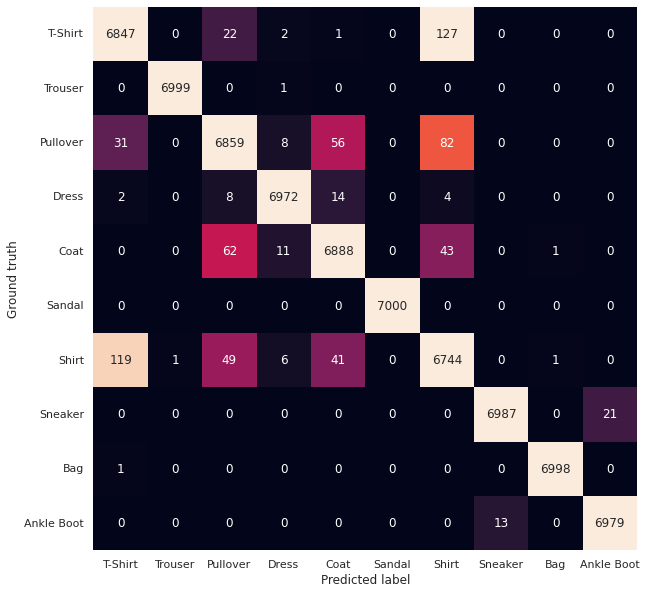

In [26]:
plot_size = 10

cm_copy = np.copy(cm)
np.fill_diagonal(cm_copy, 0)
vmax = np.max(cm_copy)
df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(plot_size, plot_size))
sns.heatmap(df, vmax=vmax, annot=True, fmt='d', cbar=False, square=True).set(xlabel='Predicted label', ylabel='Ground truth')
plt.yticks(rotation=0)
plt.show()

In [30]:
def plot_misclassified(ground_truth, predicted_label, start_idx, n):
    mask = torch.logical_and(y == label_map_reverse(ground_truth), pred == label_map_reverse(predicted_label))
    indices = mask.nonzero()
    subset = [dataset_to_analyze[i] for i in indices][start_idx:start_idx + n]
    print(f'\'{ground_truth}\' classified as \'{pred_label}\'')
    plot_dataset(subset)
    
# plot_misclassified('T-Shirt', 'Shirt', 5000, 48)
# plot_misclassified('Shirt', 'T-Shirt', 0, 48)